# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Ayush Kamleshbhai Patel
#### Student ID: 3891013


Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy

## Introduction
### Task 2: Generating Feature Representations for Job Advertisement Descriptions

- **Objective**: Produce various feature representations for job advertisements, focusing only on the job description.
- **Features**:
  - **Bag-of-words model**:
    - Generate Count vector representation for each job advertisement description based on the vocabulary from Task 1.
  - **Models based on word embeddings**:
    - Use an embedding language model (e.g., FastText, GoogleNews300, Word2Vec, or Glove).
    - Build both TF-IDF weighted and unweighted vector representations for each job advertisement description using the selected language model.
- **Output File**: 
  - `count_vectors.txt`: Contains the sparse count vector representation of job advertisement descriptions. Each line corresponds to one advertisement in a specified format.

### Task 3: Job Advertisement Classification

- **Objective**: Construct machine learning models to classify the category of a job advertisement.
- **Experiments**:
  - **Q1: Language model comparisons**:
    - Evaluate which previously built language model performs best with the chosen machine learning model.
  - **Q2: Does more information provide higher accuracy?**:
    - Investigate the effect of using different features:
      1. Only the title of the job advertisement.
      2. Only the description (already done in Task 3).
      3. Both the title and description combined.
- **Evaluation**:
  - Models' performance should be evaluated using 5-fold cross validation.

## Importing libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models import FastText
from sklearn.decomposition import PCA
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# logging for event tracking
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

#### Loading the data

In [3]:
# reading the labels file
import pandas as pd
df = pd.read_csv('jobs_data.csv')
df.head()

,Webindex,Title,Company,Description,Tokenized Description,Tokenized Title,Tokenized Company,Category
0,68997528,Finance / Accounts Asst Bromley to ****k,First Recruitment Services,Accountant (partqualified) to **** p.a. South ...,"['accountant', 'partqualified', 'south', 'east...","['finance', 'accounts', 'asst', 'bromley', 'to...","['first', 'recruitment', 'services']",Accounting_Finance
1,68063513,Fund Accountant Hedge Fund,Austin Andrew Ltd,One of the leading Hedge Funds in London is cu...,"['hedge', 'funds', 'london', 'recruiting', 'fu...","['fund', 'accountant', 'hedge', 'fund']","['austin', 'andrew', 'ltd']",Accounting_Finance
2,68700336,Deputy Home Manager,Caritas,An exciting opportunity has arisen to join an ...,"['exciting', 'arisen', 'establish', 'provider'...","['deputy', 'home', 'manager']",['caritas'],Healthcare_Nursing
3,67996688,Brokers Wanted Imediate Start,OneTwoTrade,OneTwoTrade is expanding their Sales Team and ...,"['expanding', 'recruiting', 'junior', 'trainee...","['brokers', 'wanted', 'imediate', 'start']",['onetwotrade'],Accounting_Finance
4,71803987,RGN Nurses (Hospitals) Penarth,Swiis Healthcare,RGN Nurses (Hospitals) Immediate fulltime and ...,"['rgn', 'nurses', 'hospitals', 'fulltime', 'pa...","['rgn', 'nurses', 'hospitals', 'penarth']","['swiis', 'healthcare']",Healthcare_Nursing


Readung the job advertisement text, and creating another list to store the tokenized version of the advertisements('title' and 'description') text accordingly.

In [4]:
txt_fname = 'description.txt'
with open(txt_fname) as txtf:
    description = txtf.read().splitlines() # reading a list of strings, each for a document/article
    titles = txtf.read().splitlines()
tk_description = [a.split(' ') for a in description]
tk_title = [t.split(' ') for t in description]

In [5]:
titles_fname = 'title.txt'
with open(txt_fname) as txtf:
    titles = txtf.read().splitlines()
tk_title = [t.split(' ') for t in description]
import string
tk_title = [list(map(lambda term: term.lower().translate(str.maketrans('', '', string.punctuation)), doc)) for doc in tk_title]

In [6]:
df['Description'] = description
df['Tokenized Description'] = tk_description
df['Tokenized Title'] = tk_title
df.sample(n = 5) # look at a few examples

,Webindex,Title,Company,Description,Tokenized Description,Tokenized Title,Tokenized Company,Category
424,71196096,Project Manager (Glass Partitioning Projects),Calco Services Limited,established partitioning seeking project bucki...,"[established, partitioning, seeking, project, ...","[established, partitioning, seeking, project, ...","['calco', 'services', 'limited']",Engineering
664,46634833,Staff Nurse Job Bingley (angiography suite),NaN,ref vac title staff nurse angiography suite lo...,"[ref, vac, title, staff, nurse, angiography, s...","[ref, vac, title, staff, nurse, angiography, s...",['na'],Healthcare_Nursing
517,69083137,Technical Support/Product Design Engineer,Automation Experts,technical product design engineer reference se...,"[technical, product, design, engineer, referen...","[technical, product, design, engineer, referen...","['automation', 'experts']",Engineering
441,71099289,C&I Engineering Consultant,London4Jobs,offering fantastic engineering consultant part...,"[offering, fantastic, engineering, consultant,...","[offering, fantastic, engineering, consultant,...","['london', 'jobs']",Engineering
466,69600287,Dividends / Corporate Actions Administrator,ISL UK,financial provider require individual dividend...,"[financial, provider, require, individual, div...","[financial, provider, require, individual, div...","['isl', 'uk']",Accounting_Finance


In [7]:
words = list(chain.from_iterable(tk_description))
# set of unique words
vocab = sorted(list(set(words)))
# total number

### Bag Of Words Model

<h3 style = "color: #00FF00"> Creating Binary Vectors

In [8]:
# Code to perform the task...
joined_description = [' '.join(review) for review in tk_description]
bVectorizer = CountVectorizer(analyzer = "word",binary = True,vocabulary = vocab) # initialise the CountVectorizer
binary_features = bVectorizer.fit_transform(joined_description)
binary_features.shape

(776, 5168)

<h3 style = "color: #00FF00"> Creating Count Vectors

<h4 style="color: #4169E1">The following code cell generates Count vector 
representation for each job advertisement description using the FastText model

In [9]:
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab) # initialised the CountVectorizer
count_features = cVectorizer.fit_transform(joined_description)
count_features.shape

(776, 5168)

In [10]:
count_features_df = pd.DataFrame(count_features.toarray(), columns=cVectorizer.get_feature_names_out())
# print out samples
count_features_df.head(3)

,aap,aaron,aat,abb,abenefit,aberdeen,abi,abilities,abreast,abroad,...,years,yeovil,yn,york,yorkshire,youmust,young,younger,yrs,zest
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3 style = "color: #00FF00"> Saving it into the file

In [11]:
webindex = df['Webindex']
count_features = cVectorizer.fit_transform(joined_description).toarray()

def save_count_vector(count_features, webindex, filename):
    with open(filename, 'w') as f:
        for i in range(len(count_features)):
            f.write('#' + str(webindex[i]) + ',')
            for j in range(len(count_features[i])):
                if count_features[i][j] != 0:
                    f.write(str(j) + ':' + str(count_features[i][j]) + ',')
            f.write('\n')
    f.close()
    print('Count vector representation saved to ' + filename)


save_count_vector(count_features, webindex, 'count_vectors.txt')

Count vector representation saved to count_vectors.txt


<h3 style = "color: #00FF00"> Creating TF-IDF Vectors

In [12]:
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # initialised the TfidfVectorizer
tfidf_features = tVectorizer.fit_transform(joined_description) # generate the tfidf vector representation for all job description
tfidf_features.shape

(776, 5168)

In [13]:
def write_vectorFile(data_features,filename):
    num = data_features.shape[0] # the number of document
    out_file = open(filename, 'w') # creates a txt file and open to save the vector representation
    for a_ind in range(0, num): # loop through each job description by index
        for f_ind in data_features[a_ind].nonzero()[1]: # for each word index that has non-zero entry in the data_feature
            value = data_features[a_ind][0,f_ind] # retrieve the value of the entry from data_features
            out_file.write("{}:{} ".format(f_ind,value)) # write the entry to the file in the format of word_index:value
        out_file.write('\n') # start a new line after each job description
    out_file.close() # close the file  

In [14]:
tfidf_features_file = "jobs_data_vector.txt" # file name of the tfidf vector

write_vectorFile(tfidf_features,tfidf_features_file) # write the tfidf vector to file

<h2 style="color: #FFFF00"> Creating Model based on word embeddings

<h3 style = "color: #00FF00"> Creating and Saving <b>FastText</b> Model

The functions below will help us to carry out the remaining tasks of the requirements.

### Summary of Functions:

1. **docvecs**: 
   - Generates document embeddings by averaging the word embeddings of the words present in the document.
   
2. **plotTSNE**:
   - Provides a t-SNE visualization of document embeddings. This is useful for visualizing the distribution and clustering of documents in a 2D space.

3. **weighted_docvecs**:
   - Generates document embeddings weighted by their TF-IDF values. This gives more importance to terms that are more significant in the document.

4. **gen_vocIndex**:
   - Creates a dictionary that maps from vocabulary indices to their corresponding words. This helps in referencing words using their indices.

5. **doc_wordweights**:
   - Constructs a list of dictionaries where each dictionary represents a document. The keys in the dictionary are words, and the values are their corresponding TF-IDF weights.


In [15]:
def docvecs(embeddings, docs):
    """
    Generate document embeddings by averaging word embeddings.
    
    Args:
    - embeddings: Pre-trained word embeddings model.
    - docs: List of tokenized documents.

    Returns:
    - Numpy array of document embeddings.
    """
    vecs = np.zeros((len(docs), embeddings.vector_size))
    for i, doc in enumerate(docs):
        valid_keys = [term for term in doc if term in embeddings.key_to_index]
        docvec = np.vstack([embeddings[term] for term in valid_keys])
        docvec = np.sum(docvec, axis=0)  # Summing up word vectors for the entire document
        vecs[i,:] = docvec
    return vecs

import numpy as np
def plotTSNE(labels,features):
    """
    Plot t-SNE visualization of document embeddings.
    
    Args:
    - labels: Pandas series of document labels.
    - features: Numpy array of document embeddings.

    Returns:
    - None (Displays a scatter plot).
    """
    categories = sorted(labels.unique())
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(3891013)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=3891013).fit_transform(features[indices].astype(int))
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.")
    plt.legend()
    plt.show()

def weighted_docvecs(embeddings, tfidf, docs):
    """
    Generate TF-IDF weighted document embeddings.
    
    Args:
    - embeddings: Pre-trained word embeddings model.
    - tfidf: List of dictionaries with tf-idf weights for each document.
    - docs: List of tokenized documents.

    Returns:
    - Numpy array of weighted document embeddings.
    """
    vecs = np.zeros((len(docs), embeddings.vector_size))
    for i, doc in enumerate(docs):
        valid_keys = [term for term in doc if term in embeddings.key_to_index]
        tf_weights = [float(tfidf[i].get(term, 0.)) for term in valid_keys]
        weighted = [embeddings[term] * w for term, w in zip(valid_keys, tf_weights)]
        docvec = np.vstack(weighted)
        docvec = np.sum(docvec, axis=0)  # Summing up weighted word vectors for the entire document
        vecs[i,:] = docvec
    return vecs

def gen_vocIndex(voc_fname):
    """
    Generate a dictionary mapping from vocabulary indices to words.
    
    Args:
    - voc_fname: Path to the vocabulary file.

    Returns:
    - Dictionary with vocabulary index as key and corresponding word as value.
    """
    with open(voc_fname) as vocf: 
        voc_Ind = [l.split(':') for l in vocf.read().splitlines()]
    return {int(vi[1]):vi[0] for vi in voc_Ind}

# Generates the w_index:word dictionary
voc_fname = 'vocab.txt'
voc_dict = gen_vocIndex(voc_fname)

def doc_wordweights(fName_tVectors, voc_dict):
    """
    Generate a list of dictionaries with tf-idf weights for each document.
    
    Args:
    - fName_tVectors: Path to the file containing tf-idf vectors.
    - voc_dict: Dictionary with vocabulary index as key and word as value.

    Returns:
    - List of dictionaries with words as keys and their tf-idf weights as values for each document.
    """
    tfidf_weights = []
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines()
    for tv in tVectors:
        tv = tv.strip()
        weights = tv.split(' ')
        weights = [w.split(':') for w in weights]
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights}
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

fName_tVectors = 'jobs_data_vector.txt'
tfidf_weights = doc_wordweights(fName_tVectors, voc_dict)


We create a dataframe to store accuracy of different models we will use in the subsequent steps  

In [16]:
df_results = pd.DataFrame(columns=['Model', 'Accuracy'])
performence  = pd.DataFrame(columns=['Title', 'accuracy'])

In [17]:
from gensim.models.fasttext import FastText

# 1. Set the corpus file names/path
corpus_file = 'description.txt'

# 2. Initialise the Fast Text model
descFT = FastText(vector_size=50) 

# 3. build the vocabulary
descFT.build_vocab(corpus_file=corpus_file)

# 4. train the model
descFT.train(
    corpus_file=corpus_file, epochs=descFT.epochs,
    total_examples=descFT.corpus_count, total_words=descFT.corpus_total_words,
)

print(descFT)

2023-10-08 03:22:59,058 : INFO : FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=50, alpha=0.025>', 'datetime': '2023-10-08T03:22:59.058226', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:17:16) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'created'}
2023-10-08 03:22:59,058 : INFO : collecting all words and their counts
2023-10-08 03:22:59,059 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-10-08 03:22:59,071 : INFO : collected 5168 word types from a corpus of 81205 raw words and 776 sentences
2023-10-08 03:22:59,071 : INFO : Creating a fresh vocabulary
2023-10-08 03:22:59,076 : INFO : FastText lifecycle event {'msg': 'effective_min_count=5 retains 2741 unique words (53.04% of original 5168, drops 2427)', 'datetime': '2023-10-08T03:22:59.075995', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:17:16) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'prepare

FastText<vocab=2741, vector_size=50, alpha=0.025>


In [18]:
descFT_wv = descFT.wv
print(descFT_wv)

FastTextKeyedVectors<vector_size=50, 2741 keys>


In the cell below, we save the trained model. For new I have commented it out because we use the already saved and trained model 

In [19]:
# Save the model
# descFT.save("models/FastText/descFT.model")

We can retrieve the KeyedVectors from the model as follows

In [20]:
from gensim.models.fasttext import FastText
descFT = FastText.load("models/FastText/descFT.model")
print(descFT)
descFT_wv= descFT.wv

2023-10-08 03:23:00,295 : INFO : loading FastText object from models/FastText/descFT.model
2023-10-08 03:23:00,298 : INFO : loading wv recursively from models/FastText/descFT.model.wv.* with mmap=None
2023-10-08 03:23:00,298 : INFO : loading vectors_ngrams from models/FastText/descFT.model.wv.vectors_ngrams.npy with mmap=None
2023-10-08 03:23:00,368 : INFO : setting ignored attribute vectors to None
2023-10-08 03:23:00,368 : INFO : setting ignored attribute buckets_word to None
2023-10-08 03:23:00,423 : INFO : setting ignored attribute cum_table to None
2023-10-08 03:23:00,431 : INFO : FastText lifecycle event {'fname': 'models/FastText/descFT.model', 'datetime': '2023-10-08T03:23:00.431265', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:17:16) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'loaded'}


FastText<vocab=2741, vector_size=50, alpha=0.025>


<h4 style="color: #4169E1"> The following code cell generates unweighted vector 
representation for each job advertisement description using the FastText model

In [21]:
descFT_dvs = docvecs(descFT_wv, df['Tokenized Description'])

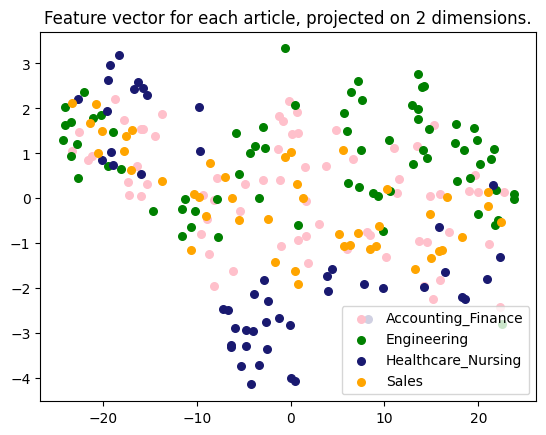

In [22]:
# explore feature space
features = descFT_dvs
plotTSNE(df['Category'],features)

<p style="color: #FFA500">The above graph is for unweighted feature vector projection for each tokenized job description

The following code cell: -

- Defines a `LogisticRegression` model.
- Splits data into training and test sets.
- Performs 5-fold cross-validation on training data:
  - Train on each fold.
  - Validate and compute accuracy.
- Trains the model on the unweighted feature represntation for tokenized job descriptions
- Evaluates on test set and display a confusion matrix.

Fold 1: Accuracy: 0.8077
Fold 2: Accuracy: 0.8173
Fold 3: Accuracy: 0.8173
Fold 4: Accuracy: 0.7692
Fold 5: Accuracy: 0.6990
Average Cross-Validation Accuracy: 0.7821


/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

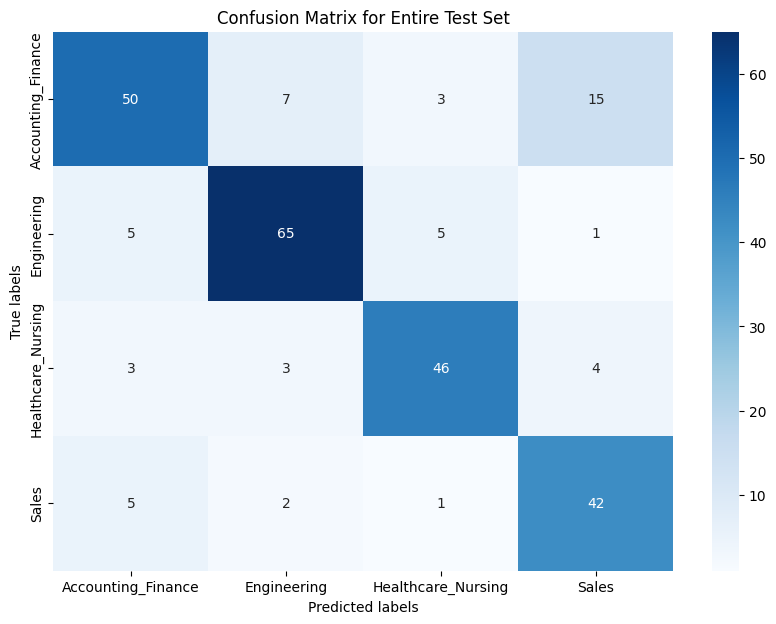

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=3891013)

# Splitting data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(descFT_dvs, df['Category'], list(range(0,len(df))), test_size=0.33, random_state=3891013)

# Setting up the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=3891013)
fold_num = 1
scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    scores.append(score)
    print(f"Fold {fold_num}: Accuracy: {score:.4f}")
    
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    
    '''
    the following piece of code which is commented will generate confusion matrix for each fold
    '''
    # # Plotting
    # plt.figure(figsize=(10,7))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for Fold {fold_num}')
    # plt.show()
    
    fold_num += 1

avg_score = sum(scores) / len(scores)
print(f"Average Cross-Validation Accuracy: {avg_score:.4f}")
df_results.loc[len(df_results)] = ['unweighted vector(using in-house trained FastText)', avg_score]
performence.loc[len(performence)] = ['Unweighted Vectors for Description', avg_score]

# After the 5-fold CV, fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Test Set')
plt.show()


<h3 style = "color: #00FF00"> Generating TF-IDF weighted document vectors

In [24]:
def gen_vocIndex(voc_fname):
    with open(voc_fname) as vocf: 
        voc_Ind = [l.split(':') for l in vocf.read().splitlines()] # each line is 'index,word'
    return {int(vi[1]):vi[0] for vi in voc_Ind}


# Generates the w_index:word dictionary
voc_fname = 'vocab.txt' # path for the vocabulary
voc_dict = gen_vocIndex(voc_fname)
voc_dict

{0: 'aap',
 1: 'aaron',
 2: 'aat',
 3: 'abb',
 4: 'abenefit',
 5: 'aberdeen',
 6: 'abi',
 7: 'abilities',
 8: 'abreast',
 9: 'abroad',
 10: 'absence',
 11: 'absolute',
 12: 'ac',
 13: 'aca',
 14: 'academic',
 15: 'academy',
 16: 'acca',
 17: 'accept',
 18: 'acceptable',
 19: 'acceptance',
 20: 'accepted',
 21: 'access',
 22: 'accessible',
 23: 'accident',
 24: 'accommodates',
 25: 'accommodation',
 26: 'accomplished',
 27: 'accordance',
 28: 'account',
 29: 'accountabilities',
 30: 'accountability',
 31: 'accountable',
 32: 'accountancy',
 33: 'accountant',
 34: 'accountants',
 35: 'accounting',
 36: 'accounts',
 37: 'accreditation',
 38: 'accredited',
 39: 'accruals',
 40: 'accuracy',
 41: 'accurate',
 42: 'accurately',
 43: 'achievable',
 44: 'achieve',
 45: 'achieved',
 46: 'achievement',
 47: 'achievements',
 48: 'achiever',
 49: 'achieving',
 50: 'acii',
 51: 'acquired',
 52: 'acquisition',
 53: 'acquisitions',
 54: 'act',
 55: 'acting',
 56: 'action',
 57: 'actions',
 58: 'action

- the `doc_wordweights` function takes the tfidf document vector file, as well as the w_index:word dictionary, creates the mapping between w_index and the actual word, and creates a dictionary of word:weight or each unique word appear in the document.

In [25]:
def doc_wordweights(fName_tVectors, voc_dict):
    tfidf_weights = [] # a list to store the  word:weight dictionaries of documents
    
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines() # each line is a tfidf vector representation of a document in string format 'word_index:weight word_index:weight .......'
    for tv in tVectors: # for each tfidf document vector
        tv = tv.strip()
        weights = tv.split(' ') # list of 'word_index:weight' entries
        weights = [w.split(':') for w in weights] # change the format of weight to a list of '[word_index,weight]' entries
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} # construct the weight dictionary, where each entry is 'word:weight'
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

fName_tVectors = 'jobs_data_vector.txt'
tfidf_weights = doc_wordweights(fName_tVectors, voc_dict)

In [26]:
# take a look at the tfidf word weights dictionary of the first document
tfidf_weights[0]

{'terms': '0.1308521762366382',
 'south': '0.20612279476719383',
 'requirement': '0.1249811292375601',
 'reconciliation': '0.14183179957804745',
 'qualified': '0.07821166567368464',
 'purchase': '0.13660500449583682',
 'previous': '0.08245826258151072',
 'possess': '0.10970668693524623',
 'phone': '0.11922830097836144',
 'person': '0.09046563231320097',
 'permanent': '0.08174449947711492',
 'payment': '0.13824362212075778',
 'partqualified': '0.173326820839609',
 'part': '0.07189780182251101',
 'offices': '0.11518385918795168',
 'negotiating': '0.15985275501239027',
 'modern': '0.13218581222143622',
 'manufacturing': '0.09726367012728679',
 'london': '0.16839249893971672',
 'letter': '0.12835773375082868',
 'ledger': '0.27321000899167364',
 'ideal': '0.08802432794046589',
 'handling': '0.24392130714952515',
 'fully': '0.1061919231001392',
 'exceptional': '0.12835773375082868',
 'email': '0.07884175705492424',
 'east': '0.20514266820633364',
 'duties': '0.08294417258358575',
 'debts': '

<h4 style="color: #4169E1">The following code cell generates TF-IDF weighted vector 
representation for each job advertisement description using the FastText model

In [27]:
weighted_descFT_dvs = weighted_docvecs(descFT_wv, tfidf_weights, df['Tokenized Description'])

And we can do very much the same thing as what we do before for other models. 
Here, we will do this as loops, for each model:
- we plot out the feature vectors  projected in a 2-dimensional space,then 
- we build the logistic regression model for document classfication and report the model performance.

Weighted In-house FastText: tSNE 2 dimensional projected Feature space


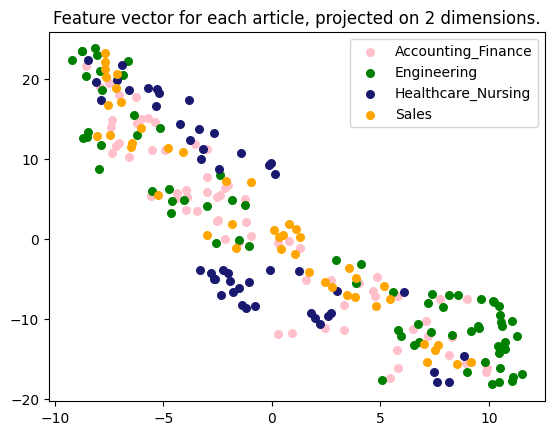

In [28]:
%matplotlib inline
seed = 3891013
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


dv = weighted_descFT_dvs
name = "Weighted In-house FastText"
print(name + ": tSNE 2 dimensional projected Feature space")
plotTSNE(df['Category'],dv)

<p style="color: #FFA500">The above graph is for weighted feature vector projection for each tokenized job description

The following code cell: -

- Defines a `LogisticRegression` model.
- Splits data into training and test sets.
- Performs 5-fold cross-validation on training data:
  - Train on each fold.
  - Validate and compute accuracy.
- Trains the model on the TF-IDF weighted feature represntation for tokenized job descriptions
- Evaluates on test set and display a confusion matrix.

Fold 1: Accuracy: 0.7885
Fold 2: Accuracy: 0.8077
Fold 3: Accuracy: 0.7885
Fold 4: Accuracy: 0.7500
Fold 5: Accuracy: 0.6990
Average Cross-Validation Accuracy: 0.7667


/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

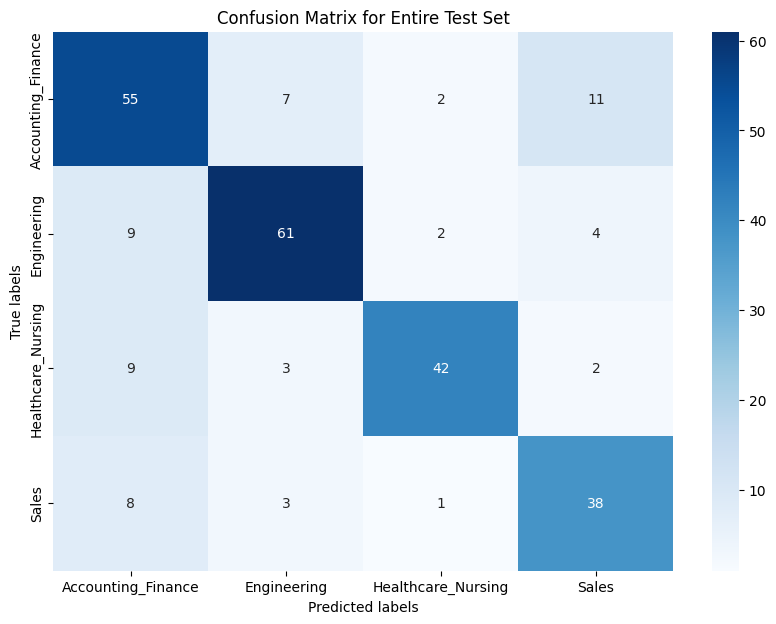

In [29]:
%matplotlib inline
seed = 3891013
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# creating training and test split
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(dv, df['Category'], list(range(0, len(df))), test_size=0.33, random_state=3891013)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=3891013)

kf = KFold(n_splits=5, shuffle=True, random_state=3891013)
fold_num = 1
scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    scores.append(score)
    print(f"Fold {fold_num}: Accuracy: {score:.4f}")
    
    '''
    the following piece of code which is commented will generate confusion matrix for each fold
    '''
    # Confusion matrix for the current fold
    # cm = confusion_matrix(y_val_fold, y_pred_fold)
    # plt.figure(figsize=(10,7))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for Fold {fold_num}')
    # plt.show()
    
    fold_num += 1

avg_score = sum(scores) / len(scores)
print(f"Average Cross-Validation Accuracy: {avg_score:.4f}")
df_results.loc[len(df_results)] = ['weighted TF-IDF vector(using in-house trained FastText)', avg_score]
performence.loc[len(performence)] = ['Weighted Vectors for Description', avg_score]

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix for the entire test set
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Test Set')
plt.show()


### Language model comparisons

#### Based Upon Count Features

The following code cell: -

- Defines a `LogisticRegression` model.
- Splits data into training and test sets.
- Performs 5-fold cross-validation on training data:
  - Train on each fold.
  - Validate and compute accuracy.
- Trains the model on the Count vector 
representation for tokenized job descriptions
- Evaluates on test set and display a confusion matrix.

Fold 1: Accuracy: 0.8942
Fold 2: Accuracy: 0.8750
Fold 3: Accuracy: 0.8558
Fold 4: Accuracy: 0.8269
Fold 5: Accuracy: 0.8058
Average Cross-Validation Accuracy: 0.8515


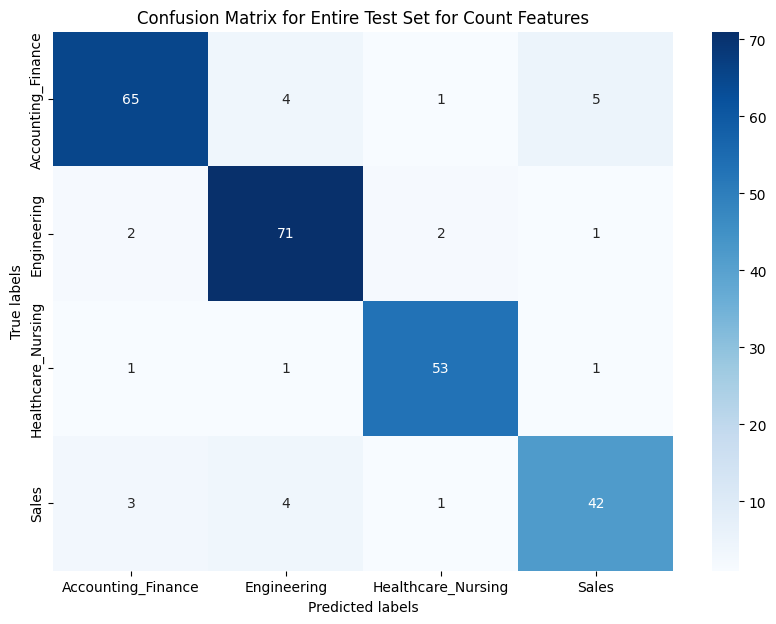

In [30]:
model = LogisticRegression(max_iter=200, random_state=3891013)

# Splitting data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(count_features, df['Category'], list(range(0,len(df))), test_size=0.33, random_state=3891013)

# Setting up the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=3891013)
fold_num = 1
scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    scores.append(score)
    print(f"Fold {fold_num}: Accuracy: {score:.4f}")
    
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    
    '''
    the following piece of code which is commented will generate confusion matrix for each fold
    '''
    # # Plotting
    # plt.figure(figsize=(10,7))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for Fold {fold_num}')
    # plt.show()
    
    fold_num += 1

avg_score = sum(scores) / len(scores)
print(f"Average Cross-Validation Accuracy: {avg_score:.4f}")
df_results.loc[len(df_results)] = ['Count Features', avg_score]

# After the 5-fold CV, fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Test Set for Count Features')
plt.show()

<h3 style="color: #FFA500">Answer for Q1: Language model comparisons

In [31]:
df_results

,Model,Accuracy
0,unweighted vector(using in-house trained FastT...,0.782114
1,weighted TF-IDF vector(using in-house trained ...,0.766729
2,Count Features,0.851550


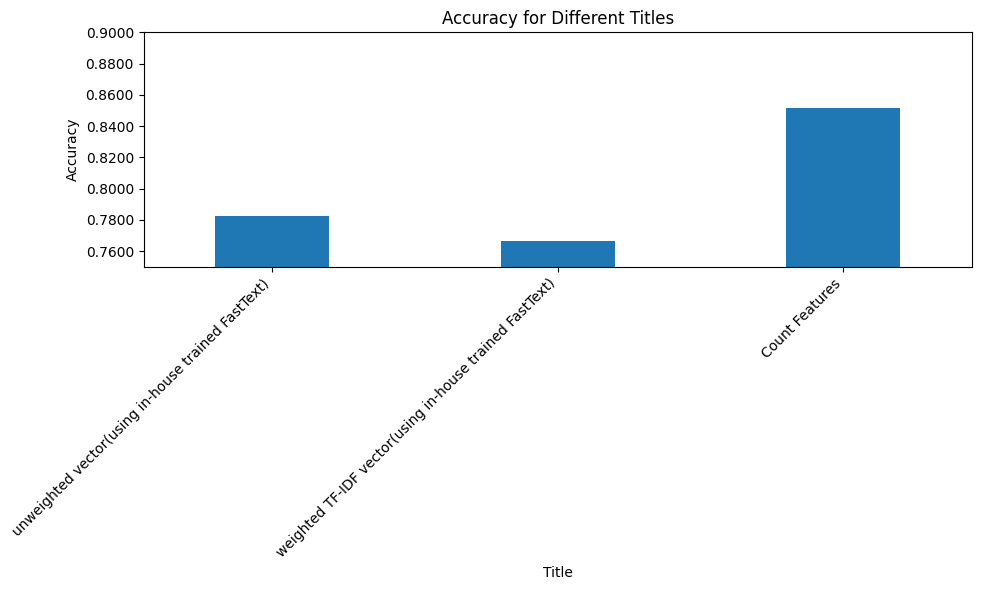

In [32]:
ax = df_results.plot(x='Model', y='Accuracy', kind='bar', legend=False, figsize=(10,6), width=0.4)

# Adjust the y-axis limits to focus on a range that highlights differences
# Considering the data provided, setting the range from 0.75 to 0.90
ax.set_ylim([0.75, 0.9])

# Add title and labels
plt.title('Accuracy for Different Titles')
plt.ylabel('Accuracy')
plt.xlabel('Title')
plt.xticks(rotation=45, ha='right')

# Display y-values with 4 decimal places on the y-axis
ax.yaxis.set_major_formatter('{:.4f}'.format)

# Show the plot
plt.tight_layout()
plt.show()


<h4 style="color: #00BFFF"> From the above graph, we can clearly see that we get highest accuracy for <b>Count vector representation</b> which is around 0.85 or 85 percent.

The possible reason for the oberserved output could be: -
- **Frequency Matters**: In job descriptions, important terms are often repeated for emphasis or clarity. Count Vector Representation captures this repetition.
- **Specificity of Keywords**: Job descriptions tend to have field-specific jargon or keywords that are strong indicators of the job field. Count vectors can effectively capture these unique terms.
- **High Dimensionality**: Count vectors are high-dimensional, capturing a wide array of terms from the corpus. This granularity can be beneficial for distinguishing between nuanced job fields.


<h3 style="color: #FFA500">Answer for Q2: Does more information provide higher accuracy?

<h3 style = "color: #00FF00"> Creating Models Based on Title

##### Testing Model on unweighted Title

The following code cell generates unweighted vector 
representation for each job advertisement Title using the FastText model

In [33]:
descFT_dvs_titles = docvecs(descFT_wv, df['Tokenized Title'])

The following code cell: -

- Defines a `LogisticRegression` model.
- Splits data into training and test sets.
- Performs 5-fold cross-validation on training data:
  - Train on each fold.
  - Validate and compute accuracy.
- Trains the model on the unweighted tokenized title vectors for each job advertisement
- Evaluates on test set and display a confusion matrix.

Fold 1: Accuracy: 0.7885
Fold 2: Accuracy: 0.8269
Fold 3: Accuracy: 0.8173
Fold 4: Accuracy: 0.7885
Fold 5: Accuracy: 0.7282
Average Cross-Validation Accuracy: 0.7899


/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

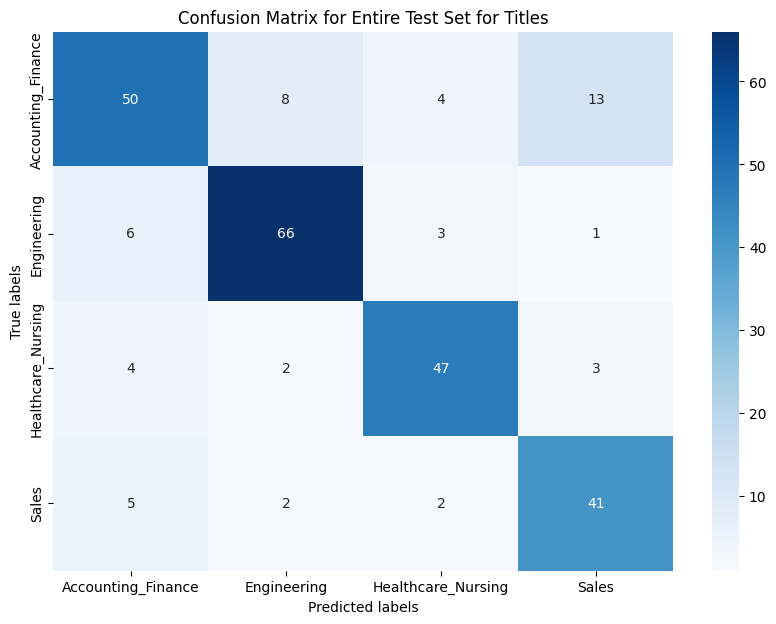

In [34]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=3891013)

# Splitting data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(descFT_dvs_titles, df['Category'], list(range(0,len(df))), test_size=0.33, random_state=3891013)

# Setting up the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=3891013)
fold_num = 1
scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    scores.append(score)
    print(f"Fold {fold_num}: Accuracy: {score:.4f}")
    
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    
    '''
    the following piece of code which is commented will generate confusion matrix for each fold
    '''
    # # Plotting
    # plt.figure(figsize=(10,7))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for Fold {fold_num}')
    # plt.show()
    
    fold_num += 1

avg_score = sum(scores) / len(scores)
print(f"Average Cross-Validation Accuracy: {avg_score:.4f}")
performence.loc[len(performence)] = ['Unweighted Vectors for Title', avg_score]

# After the 5-fold CV, fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Test Set for Titles')
plt.show()

##### Testing Model on weighted Title

The following code cell generates TF-IDF weighted vector 
representation for each job advertisement Title using the FastText model

In [35]:
weighted_descFT_dvs_title = weighted_docvecs(descFT_wv, tfidf_weights, df['Tokenized Title'])

The following code cell: -

- Defines a `LogisticRegression` model.
- Splits data into training and test sets.
- Performs 5-fold cross-validation on training data:
  - Train on each fold.
  - Validate and compute accuracy.
- Trains the model on the TF-IDF weighted tokenized title vectors for each job advertisement
- Evaluates on test set and display a confusion matrix.

Fold 1: Accuracy: 0.7885
Fold 2: Accuracy: 0.7981
Fold 3: Accuracy: 0.7885
Fold 4: Accuracy: 0.7500
Fold 5: Accuracy: 0.6893
Average Cross-Validation Accuracy: 0.7629


/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

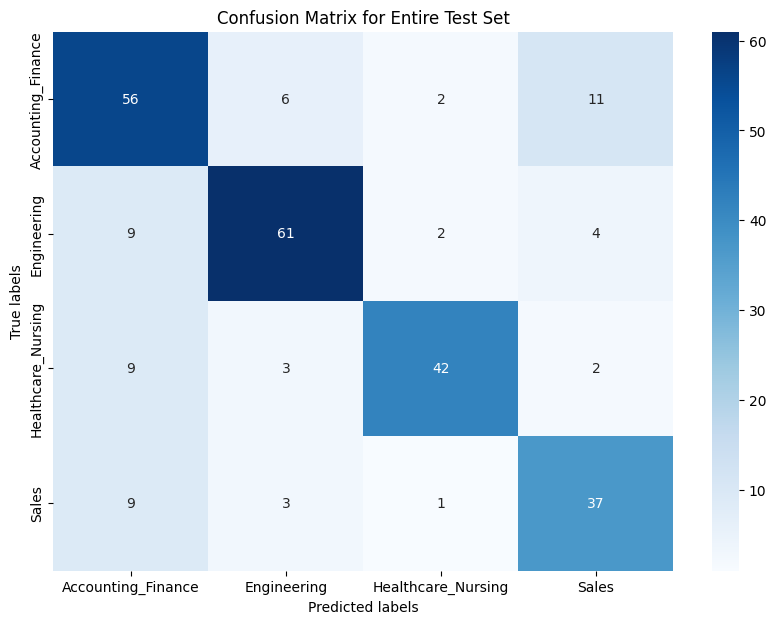

In [36]:


# creating training and test split
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(weighted_descFT_dvs_title, df['Category'], list(range(0, len(df))), test_size=0.33, random_state=3891013)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=3891013)

kf = KFold(n_splits=5, shuffle=True, random_state=3891013)
fold_num = 1
scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    scores.append(score)
    print(f"Fold {fold_num}: Accuracy: {score:.4f}")
    
    '''
    the following piece of code which is commented will generate confusion matrix for each fold
    '''
    # Confusion matrix for the current fold
    # cm = confusion_matrix(y_val_fold, y_pred_fold)
    # plt.figure(figsize=(10,7))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for Fold {fold_num}')
    # plt.show()
    
    fold_num += 1

avg_score = sum(scores) / len(scores)
print(f"Average Cross-Validation Accuracy: {avg_score:.4f}")
performence.loc[len(performence)] = ['Weighted Vectors for Title', avg_score]

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix for the entire test set
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Test Set')
plt.show()

In [37]:
performence

,Title,accuracy
0,Unweighted Vectors for Description,0.782114
1,Weighted Vectors for Description,0.766729
2,Unweighted Vectors for Title,0.789862
3,Weighted Vectors for Title,0.762864


<h3 style = "color: #00FF00"> Creating Model based on Title+Description

##### Testing Model on **unweighted** Title+Description

The following code cell generates unweighted vector 
representation for each job advertisement Title+Description using the FastText model

In [38]:
descFT_dvs_titles_and_desc = docvecs(descFT_wv, df['Tokenized Title']+df['Tokenized Description'])

The following code cell: -

- Defines a `LogisticRegression` model.
- Splits data into training and test sets.
- Performs 5-fold cross-validation on training data:
  - Train on each fold.
  - Validate and compute accuracy.
- Trains the model on the unweighted tokenized title+description(concatinated) vectors for each job advertisement
- Evaluates on test set and display a confusion matrix.

Fold 1: Accuracy: 0.7885
Fold 2: Accuracy: 0.7981
Fold 3: Accuracy: 0.8173
Fold 4: Accuracy: 0.7788
Fold 5: Accuracy: 0.7087
Average Cross-Validation Accuracy: 0.7783


/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

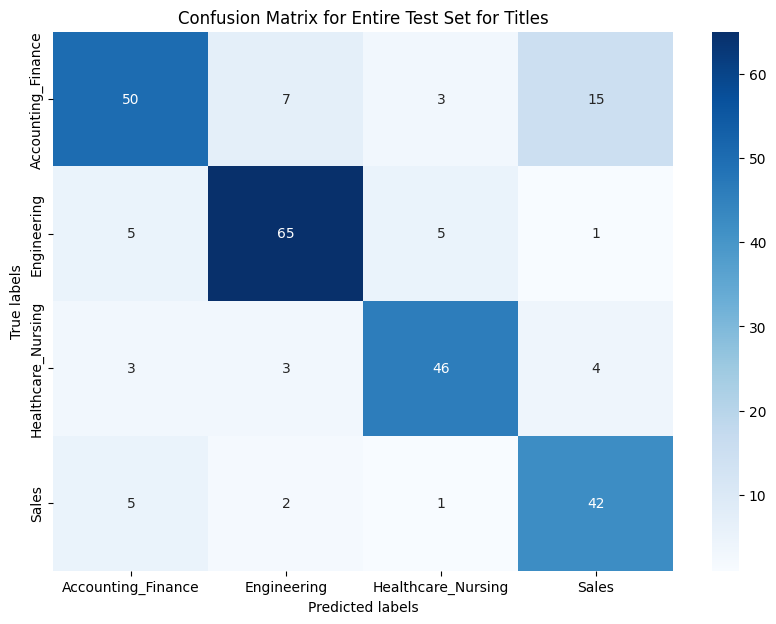

In [39]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=3891013)

# Splitting data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(descFT_dvs_titles_and_desc, df['Category'], list(range(0,len(df))), test_size=0.33, random_state=3891013)

# Setting up the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=3891013)
fold_num = 1
scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    scores.append(score)
    print(f"Fold {fold_num}: Accuracy: {score:.4f}")
    
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    
    '''
    the following piece of code which is commented will generate confusion matrix for each fold
    '''
    # # Plotting
    # plt.figure(figsize=(10,7))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for Fold {fold_num}')
    # plt.show()
    
    fold_num += 1

avg_score = sum(scores) / len(scores)
print(f"Average Cross-Validation Accuracy: {avg_score:.4f}")
performence.loc[len(performence)] = ['Unweighted Vectors for Title and Description Combined', avg_score]

# After the 5-fold CV, fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Test Set for Titles')
plt.show()

##### Testing Model on **weighted** Title+Description

The following code cell generates TF-IDF weighted vector 
representation for each job advertisement Title+Description using the FastText model

In [40]:
weighted_descFT_dvs_titles_and_desc = weighted_docvecs(descFT_wv, tfidf_weights, df['Tokenized Title']+df['Tokenized Description'])

The following code cell: -

- Defines a `LogisticRegression` model.
- Splits data into training and test sets.
- Performs 5-fold cross-validation on training data:
  - Train on each fold.
  - Validate and compute accuracy.
- Trains the model on the TF-IDF weighted tokenized title+description(concatinated) vectors for each job advertisement
- Evaluates on test set and display a confusion matrix.

Fold 1: Accuracy: 0.7885
Fold 2: Accuracy: 0.8173
Fold 3: Accuracy: 0.7692
Fold 4: Accuracy: 0.7596
Fold 5: Accuracy: 0.7184
Average Cross-Validation Accuracy: 0.7706


/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Text(0.5, 1.0, 'Confusion Matrix for Entire Test Set for Titles')

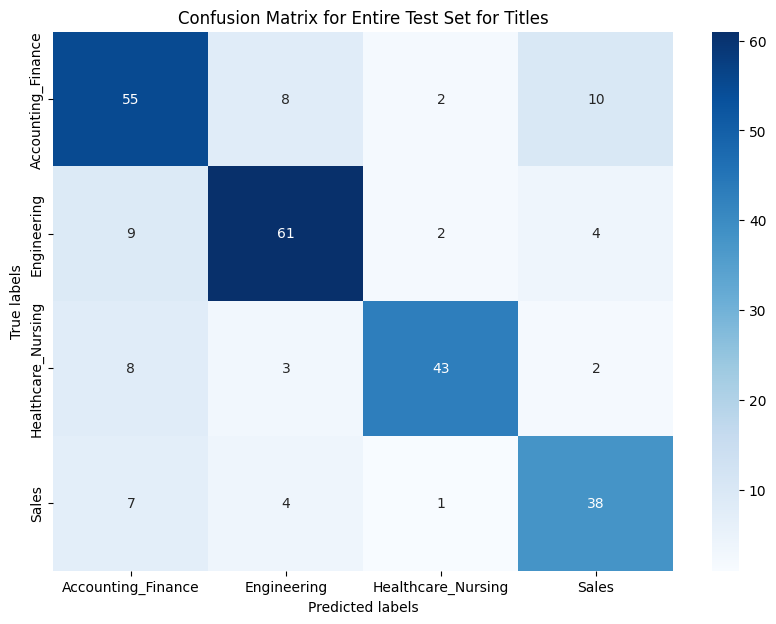

In [41]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=3891013)

# Splitting data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(weighted_descFT_dvs_titles_and_desc, df['Category'], list(range(0,len(df))), test_size=0.33, random_state=3891013)

# Setting up the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=3891013)
fold_num = 1
scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_val_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    scores.append(score)
    print(f"Fold {fold_num}: Accuracy: {score:.4f}")
    
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    
    '''
    the following piece of code which is commented will generate confusion matrix for each fold
    '''
    # # Plotting
    # plt.figure(figsize=(10,7))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for Fold {fold_num}')
    # plt.show()
    
    fold_num += 1

avg_score = sum(scores) / len(scores)
print(f"Average Cross-Validation Accuracy: {avg_score:.4f}")
performence.loc[len(performence)] = ['weighted Vectors for Title and Description Combined', avg_score]

# After the 5-fold CV, fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Test Set for Titles')

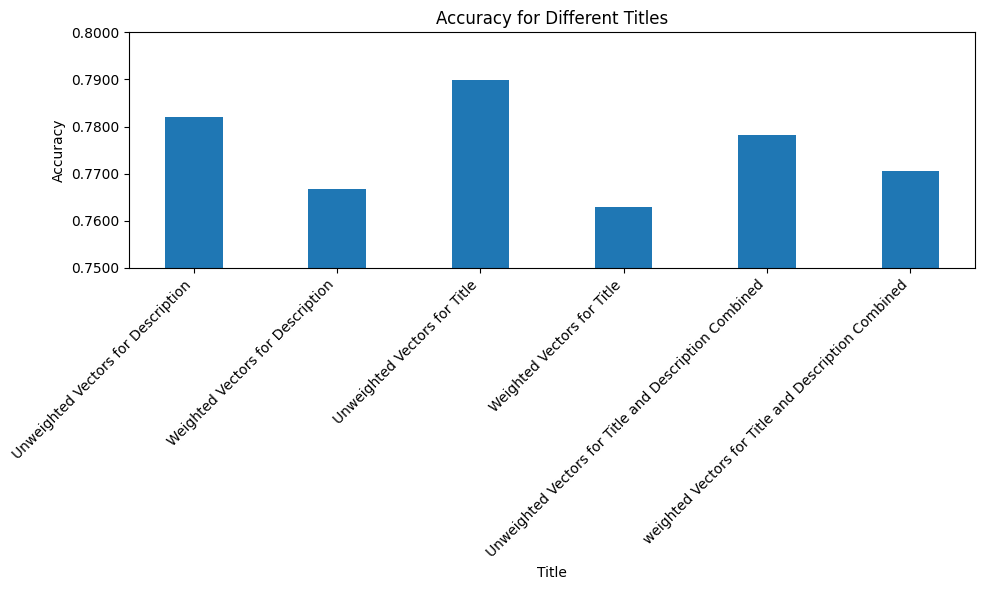

,Title,accuracy
0,Unweighted Vectors for Description,0.782114
1,Weighted Vectors for Description,0.766729
2,Unweighted Vectors for Title,0.789862
3,Weighted Vectors for Title,0.762864
4,Unweighted Vectors for Title and Description C...,0.778286
5,weighted Vectors for Title and Description Com...,0.770612


In [42]:
ax = performence.plot(x='Title', y='accuracy', kind='bar', legend=False, figsize=(10,6), width=0.4)

# Adjust the y-axis limits to focus on a range that highlights differences
# Considering the data provided, setting the range from 0.75 to 0.8
ax.set_ylim([0.75, 0.8])

# Add title and labels
plt.title('Accuracy for Different Titles')
plt.ylabel('Accuracy')
plt.xlabel('Title')
plt.xticks(rotation=45, ha='right')

# Display y-values with 4 decimal places on the y-axis
ax.yaxis.set_major_formatter('{:.4f}'.format)

# Show the plot
plt.tight_layout()
plt.show()


performence

<h4 style="color: #00BFFF">
Analysis of Job Advertisement Title and Description on Model Accuracy

**Results**:
- **Unweighted Vectors**:
  - Description Alone: `78.21%`
  - Title Alone: `78.99%`
  - Title + Description: `77.83%`

- **Weighted Vectors**:
  - Description Alone: `76.67%`
  - Title Alone: `76.29%`
  - Title + Description: `77.06%`

**Discussion**:
1. The title on its own slightly outperforms the description when using unweighted vectors.
2. With weighted vectors, the description has a slight edge over the title.
3. Combining title and description does not lead to an accuracy boost. In fact, the accuracy drops slightly compared to using just the title or description alone.

**Conclusion**:
Using the title of a job advertisement does not result in a significant accuracy boost when combined with the description, based on the current method of combination. However, the title alone possesses a good predictive capability that might be explored further.


Probable Reasons for Observed Results

1. **Redundancy**: Combining titles and descriptions might repeat information.
2. **Dilution**: Important features in titles could get diluted by longer descriptions.
3. **Different Structures**: Titles and descriptions might have distinct linguistic patterns, introducing noise when combined.
4. **Representation Limitation**: The method of vector representation might not capture the combined semantics effectively.
5. **Overfitting**: Combining could lead to overfitting, especially on smaller datasets.
6. **Merging Strategy**: Direct concatenation might not be optimal for combining the information.

In essence, while both pieces of data are valuable, the method of merging is critical.



## Summary
Give a short summary and anything you would like to talk about the assessment tasks here.

## Couple of notes for all code blocks in this notebook
- please provide proper comment on your code
- Please re-start and run all cells to make sure codes are runable and include your output in the submission.   
<span style="color: red"> This markdown block can be removed once the task is completed. </span>